In [1]:
import pypelines.supervised_pipeline as pipe
from pypelines import utils

### regression

In [2]:
utils.list_supported_models(model_type='regression')

['Elastic Net Regression',
 'Linear Regression',
 'Lasso Regression',
 'Ridge Regression',
 'SGD Regressor Regression',
 'Histogram Gradient Boost Regression',
 'Random Forest Regression',
 'AdaBoost Regression',
 'Poisson Regression',
 'Decision Tree Regression',
 'GBT Regression',
 'ExtraTree Regression',
 'GPR Regression',
 'Bayesian ARD Regression',
 'Bayesian Ridge Regression',
 'Quantile Regression',
 'Huber Regression',
 'TheilSen Regression',
 'Passive Aggressive Regression',
 'Gamma Regression',
 'Tweedie Regression',
 'OMP Regression',
 'LassoLars Regression',
 'RANSAC Regression']

In [3]:
import pandas as pd
housing = pd.read_csv("pypelines/datasets/regression/housing.csv")

### regression - all models

In [4]:
reg_pypelines_all = pipe.SupervisedPipeline(data = housing,target = 'median_house_value',predictions_data=housing
                            , model_type = 'regression'
                            , models = ['Linear Regression']
                            , nfolds = 5)

In [5]:
reg_pypelines_all.get_hyperparameters()

{'Linear Regression': {'numerical': [],
  'categorical': [{'search': False,
    'name': 'fit_intercept',
    'selected': [True],
    'values': [True, False]}]}}

In [6]:
reg_pypelines_all.model_list()

['Linear Regression']


In [7]:
reg_pypelines_all.code_to_file(path = 'code_output/')

'model files saved to code_output/'

In [8]:
reg_pypelines_all.code_to_clipboard()

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
['ocean_proximity']
[]
Fitting 5 folds for each of 1 candidates, totalling 5 fits


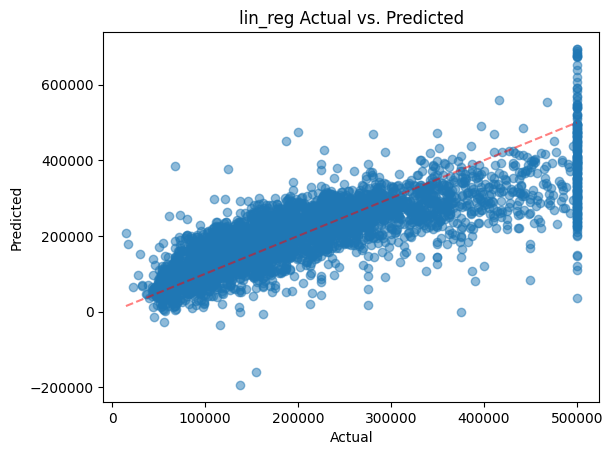

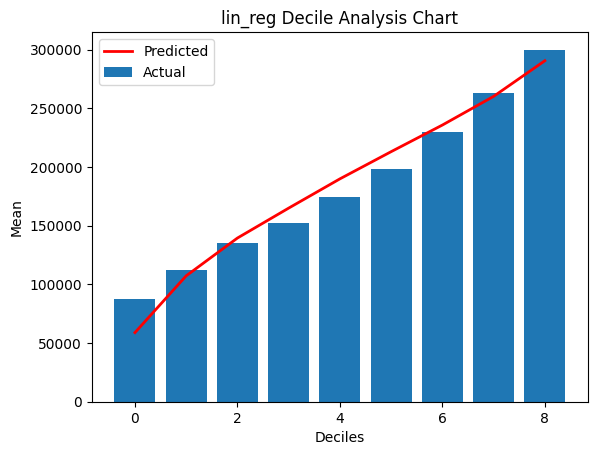

     model    metric     value
0  lin_reg  r2_score  0.625411


In [9]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# target dataframe: housing
target = "median_house_value"
features = list(housing.columns.drop("median_house_value"))
feature_df = housing[features]

prediction_df = housing

# get numerical and categorical columns
bool_cols = feature_df.select_dtypes(include=['bool']).columns.tolist()
housing[bool_cols] = feature_df[bool_cols].astype(int)
numerical_cols = feature_df.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_cols = feature_df.select_dtypes(include=['object']).columns.tolist()
text_cols = feature_df.select_dtypes(include=['string']).columns.tolist()


sample_size = np.min([10000, housing.shape[0]])
unique_theshold = np.min([100, sample_size/10])

# check categorical columns for high cardinality and make it text column
for col in categorical_cols:
    if housing[col].sample(sample_size).nunique() > unique_theshold:
        text_cols.append(col)
        categorical_cols.remove(col)
        

# check text columns for low cardinality and make it categorical columns
for col in text_cols:
    if housing[col].sample(sample_size).nunique() < unique_theshold:
        categorical_cols.append(col)
        text_cols.remove(col)

print(numerical_cols)
print(categorical_cols)
print(text_cols)

# define numeric transformer steps
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), 
        ("scaler", StandardScaler())]
)

# define categorical transformer steps
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# define text transformer steps
text_transformer = Pipeline(
    steps=[
        ('text', TfidfVectorizer())
    ]
)

# create the preprocessing pipelines for both numeric and categorical data
preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer , numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        *[(f'text_{t_col}', text_transformer, t_col) for t_col in text_cols]]
)

# train test split
X = housing[features]
y = housing[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_comparison_list = []

##### End of Data Processing Pipeline #####


##### Model Pipeline for Linear Regression #####

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,make_scorer,r2_score,explained_variance_score
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
lin_reg_param_grid = {
}


# Create the pipeline
lin_reg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('lin_reg', LinearRegression())
])

# Create the grid search
lin_reg_grid_search = GridSearchCV(estimator=lin_reg_pipe, param_grid=lin_reg_param_grid, cv=5, scoring=make_scorer(mean_squared_error), verbose=1)
lin_reg_grid_search.fit(X_train, y_train)

# Get the best hyperparameters
lin_reg_best_estimator = lin_reg_grid_search.best_estimator_

# Store results as a dataframe  
lin_reg_search_results = pd.DataFrame(lin_reg_grid_search.cv_results_)

# Model metrics

# Generate Predictions
lin_reg_predictions = lin_reg_best_estimator.predict(X_test)
lin_reg_predictions_df = pd.DataFrame(lin_reg_best_estimator.predict(X_test))

# Generate Model Metrics
lin_reg_r2_score = r2_score(y_test, lin_reg_predictions_df.iloc[:,0])
lin_reg_mean_squared_error = mean_squared_error(y_test, lin_reg_predictions_df.iloc[:,0])
lin_reg_explained_variance_score = explained_variance_score(y_test, lin_reg_predictions_df.iloc[:,0])
lin_reg_performance_metrics = [['lin_reg','r2_score', lin_reg_r2_score], 
                                  ['lin_reg','mean_squared_error',lin_reg_mean_squared_error],
                                  ['lin_reg','explained_variance_score', lin_reg_explained_variance_score]]
lin_reg_performance_metrics = pd.DataFrame(lin_reg_performance_metrics, columns=['model','metric', 'value'])

# Generate Actual vs Predicted Plot
lin_reg_actual_predicted_plot, lin_reg_actual_predicted_plot_ax = plt.subplots()
lin_reg_actual_predicted_plot = lin_reg_actual_predicted_plot_ax.scatter(x=y_test, y=lin_reg_predictions_df.iloc[:,0], alpha=0.5)
# Add diagonal line
lin_reg_actual_predicted_plot_ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', alpha=0.5)
# Set axis labels and title
lin_reg_actual_predicted_plot_ax.set_xlabel('Actual')
lin_reg_actual_predicted_plot_ax.set_ylabel('Predicted')
lin_reg_actual_predicted_plot_ax.set_title(f'lin_reg Actual vs. Predicted')
plt.show(block=False)

# Generate Decile Lift Chart
# Calculate the deciles based on the residuals
lin_reg_deciles = np.percentile(lin_reg_predictions, np.arange(0, 100, 10))
# Calculate the mean actual and predicted values for each decile
lin_reg_mean_actual = []
lin_reg_mean_predicted = []
for i in range(len(lin_reg_deciles) - 1):
    mask = (lin_reg_predictions >= lin_reg_deciles[i]) & (lin_reg_predictions < lin_reg_deciles[i + 1])
    lin_reg_mean_actual.append(np.mean(y_test[mask]))
    lin_reg_mean_predicted.append(np.mean(lin_reg_predictions[mask]))

# Create a bar chart of the mean actual and predicted values for each decile
lin_reg_lift_plot, lin_reg_lift_plot_ax = plt.subplots()
lin_reg_lift_plot_ax.bar(np.arange(len(lin_reg_mean_actual)), lin_reg_mean_actual, label='Actual')
lin_reg_lift_plot_ax.plot(np.arange(len(lin_reg_mean_predicted)), lin_reg_mean_predicted, color='red', linewidth=2, label='Predicted')
lin_reg_lift_plot_ax.set_xlabel('Deciles')
lin_reg_lift_plot_ax.set_ylabel('Mean')
lin_reg_lift_plot_ax.set_title(f'lin_reg Decile Analysis Chart')
lin_reg_lift_plot_ax.legend()
plt.show(block=False)


model_comparison_list.append(lin_reg_performance_metrics)##### End of Model Pipeline for Linear Regression #####
##### Model Comparison #####

table = pd.concat(model_comparison_list)
table = table.sort_values(by=['value'], ascending=False)
table = table[table['metric'] == 'r2_score']
print(table)
f"The best model is {table['model'].iloc[0]} with {table['value'].iloc[0]} as {table['metric'].iloc[0]}" 


# Predict test data using the best model
test_predictions = eval(table['model'].iloc[0]+"_best_estimator").predict(prediction_df)


In [ ]:
best_model_prefix = table['model'].iloc[0]
eval(best_model_prefix+"_best_estimator").predict(X_test)

In [ ]:
reg_pypelines_all.code_to_file(path = "./code_output")

### classification

In [ ]:
titanic = pd.read_csv("pypelines/datasets/classification/titanic.csv")

In [ ]:
# code output
clf_pypelines_all = pipe.SupervisedPipeline(data = titanic,target = 'Survived'
                            , model_type = 'classification'
                            , models = ['Logistic Regression']
                            , nfolds = 5)

In [ ]:
clf_pypelines_all.get_hyperparameters()

In [ ]:
clf_pypelines_all.code_to_clipboard()
clf_pypelines_all.code_to_file(path = "./code_output")

In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# target dataframe: titanic
target = "Survived"
features = list(titanic.columns.drop("Survived"))
feature_df = titanic[features]

# get numerical and categorical columns
bool_cols = feature_df.select_dtypes(include=['bool']).columns.tolist()
titanic[bool_cols] = feature_df[bool_cols].astype(int)
numerical_cols = feature_df.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_cols = feature_df.select_dtypes(include=['object']).columns.tolist()
text_cols = feature_df.select_dtypes(include=['string']).columns.tolist()


sample_size = np.min([10000, titanic.shape[0]])
unique_theshold = np.min([100, sample_size/10])

# check categorical columns for high cardinality and make it text column
for col in categorical_cols:
    if titanic[col].sample(sample_size).nunique() > unique_theshold:
        text_cols.append(col)
        categorical_cols.remove(col)
        

# check text columns for low cardinality and make it categorical columns
for col in text_cols:
    if titanic[col].sample(sample_size).nunique() < unique_theshold:
        categorical_cols.append(col)
        text_cols.remove(col)

print(numerical_cols)
print(categorical_cols)
print(text_cols)

# define numeric transformer steps
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), 
        ("scaler", StandardScaler())]
)

# define categorical transformer steps
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# define text transformer steps
text_transformer = Pipeline(
    steps=[
        ('text', TfidfVectorizer())
    ]
)

# create the preprocessing pipelines for both numeric and categorical data
preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer , numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        *[(f'text_{t_col}', text_transformer, t_col) for t_col in text_cols]]
)

# train test split
X = titanic[features]
y = titanic[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### End of Data Processing Pipeline #####


##### Model Pipeline for Logistic Regression #####

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,make_scorer,f1_score,precision_score,recall_score,roc_auc_score,roc_curve,auc
import matplotlib.pyplot as plt
log_reg_param_grid = {
"log_reg__C": np.arange(0.1, 1.0, 0.1),
}


# Create the pipeline
log_reg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression())
])

# Create the grid search
log_reg_grid_search = GridSearchCV(estimator=log_reg_pipe, param_grid=log_reg_param_grid, cv=5, scoring=make_scorer(accuracy_score), verbose=1)
log_reg_grid_search.fit(X_train, y_train)

# Get the best hyperparameters
log_reg_best_estimator = log_reg_grid_search.best_estimator_

# Store results as a dataframe  
log_reg_search_results = pd.DataFrame(log_reg_grid_search.cv_results_)

# Model metrics

# Generate Predictions
log_reg_predictions = pd.DataFrame(log_reg_best_estimator.predict(X_test))
log_reg_predictions_prob = log_reg_best_estimator.predict_proba(X_test)
log_reg_predictions_prob_df = pd.DataFrame()
log_reg_predictions_prob_df[log_reg_grid_search.classes_[0]] = log_reg_predictions_prob[:,0]
log_reg_predictions_prob_df[log_reg_grid_search.classes_[1]] = log_reg_predictions_prob[:,1] 

# Generate Model Metrics
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions.iloc[:,0])
log_reg_f1_score = f1_score(y_test, log_reg_predictions.iloc[:,0])
log_reg_precision = precision_score(y_test, log_reg_predictions.iloc[:,0])
log_reg_recall = recall_score(y_test, log_reg_predictions.iloc[:,0])
log_reg_roc_auc_score = roc_auc_score(y_test, log_reg_predictions_prob_df[log_reg_grid_search.classes_[1]])
log_reg_performance_metrics = [['log_reg','accuracy',log_reg_accuracy], 
                                  ['log_reg','f1_score',log_reg_f1_score],
                                  ['log_reg','precision', log_reg_precision],
                                  ['log_reg','recall', log_reg_recall],
                                  ['log_reg','roc_auc_score', log_reg_roc_auc_score]]
log_reg_performance_metrics = pd.DataFrame(log_reg_performance_metrics, columns=['model','metric', 'value'])
fpr, tpr, thresholds = roc_curve(y_test, log_reg_predictions_prob_df[log_reg_grid_search.classes_[1]])
roc_auc = auc(fpr, tpr)

# ROC Curve plot
log_reg_roc_auc_plot, log_reg_roc_auc_plot_ax = plt.subplots()
log_reg_roc_auc_plot_ax.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
log_reg_roc_auc_plot_ax.plot([0, 1], [0, 1], 'r--', label='Random guess')
# Set axis labels and title
log_reg_roc_auc_plot_ax.set_xlabel('False Positive Rate')
log_reg_roc_auc_plot_ax.set_ylabel('True Positive Rate')
log_reg_roc_auc_plot_ax.set_title(f'log_reg ROC Curve')
# Add legend
log_reg_roc_auc_plot_ax.legend()



# Lift Chart
aux_df = pd.DataFrame()
aux_df['y_real'] = y_test
aux_df['y_proba'] = log_reg_predictions_prob[:,1]

# Sort by predicted probability
aux_df = aux_df.sort_values('y_proba', ascending=False)

# Find the total positive ratio of the whole dataset
total_positive_ratio = sum(aux_df['y_real'] == 1) / aux_df.shape[0]

# For each line of data, get the ratio of positives of the given subset and calculate the lift
lift_values = []
for i in aux_df.index:
    threshold = aux_df.loc[i]['y_proba']
    subset = aux_df[aux_df['y_proba'] >= threshold]
    subset_positive_ratio = sum(subset['y_real'] == 1) / subset.shape[0]
    lift = subset_positive_ratio / total_positive_ratio
    lift_values.append(lift)

# Plot the lift curve
log_reg_lift_plot, log_reg_lift_plot_ax = plt.subplots()
log_reg_lift_plot_ax.set_xlabel('Proportion')
log_reg_lift_plot_ax.set_ylabel('Lift')
log_reg_lift_plot_ax.set_title(f'log_reg Lift Curve')

# plot the lift curve
x_vals = np.linspace(0, 1, num=len(lift_values))
log_reg_lift_plot_ax.plot(x_vals, lift_values, color='b')

# add dashed horizontal line at lift of 1
log_reg_lift_plot_ax.axhline(y=1, color='gray', linestyle='--', linewidth=3)



##### Model Metrics Logistic Regression #####

print(log_reg_performance_metrics)
plt.show(block=False)

##### End of Model Pipeline for Logistic Regression #####

### classification - all models

### Update grid search for a model

In [ ]:
clf_pypelines_all.model_grid_search_settings(model_name="Random Forest Classifier")

In [ ]:
rf_updated_dict = {'numerical': [{'search': True,
   'name': 'n_estimators',
   'min': 100,
   'max': 1000,
   'step': 20},
  {'search': True, 'name': 'max_depth', 'min': 2, 'max': 10, 'step': 2},
  {'search': True,
   'name': 'min_samples_split',
   'min': 0.50,
   'max': 1,
   'step': 0.1},
  {'search': True,
   'name': 'min_samples_leaf',
   'min': 1,
   'max': 10,
   'step': 2}],
 'categorical': [{'search': False,
   'name': 'criterion',
   'selected': ['gini'],
   'values': ['gini', 'entropy']},
  {'search': False,
   'name': 'max_features',
   'selected': ['sqrt'],
   'values': ['auto', 'sqrt', 'log2']},
  {'search': False,
   'name': 'bootstrap',
   'selected': [True],
   'values': [True, False]},
  {'search': True,
   'name': 'oob_score',
   'selected': [True],
   'values': [True, False]},
  {'search': False,
   'name': 'warm_start',
   'selected': [False],
   'values': [True, False]},
  {'search': False,
   'name': 'class_weight',
   'selected': ['balanced'],
   'values': ['balanced', 'balanced_subsample']}]}

In [ ]:
# Example list of dictionaries
dict_list = [rf_updated_dict]

# Loop through each dictionary in the list
for i, rf_dict in enumerate(dict_list):
    # Format the dictionary
    formatted_dict = {
        'numerical': [
            {'search': param['search'], 'name': param['name'], 'min': param['min'], 'max': param['max'], 'step': param['step']}
            for param in rf_dict['numerical']
        ],
        'categorical': [
            {'search': param['search'], 'name': param['name'], 'selected': param['selected'], 'values': param['values']}
            for param in rf_dict['categorical']
        ]
    }
    # Replace the original dictionary with the formatted one
    dict_list[i] = formatted_dict


In [ ]:
clf_pypelines_all.set_model_grid_search_settings(hyperparam_dict=rf_updated_dict,model_name = 'Random Forest Classifier')

In [ ]:
from jinja2 import Template
t = Template("Hello {{ token }}!")
#t.render(token="Jinja2")


d = Template("""
print({{prefix}}_performance_metrics) 
plt.show(block=False)
""")

d.render()